## Import if Hitran spectra

Die Notebook is used to import spectra from the Hitran database : https://www.cfa.harvard.edu/hitran/
It imports the linelists and calculates the spectrum using a voigt lineshape. 
The specrum is then stored in a file for further use in the DGA simulator

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import hapi
import sys
sys.path.append(r'C:\Data\Python\Characterisation_Report_scripts\src\analysis')
import functions

HAPI version: 1.1.0.8.8
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [2]:
#wavelengths array
wl_array = np.arange(2.5, 4.5, 0.0001)

In [3]:
#wavenumber array
wn_array = 1.0e4/wl_array[::-1]

In [4]:
#start hapi database
hapi.db_begin('hapi_db')

Using hapi_db

12CH4
                     Lines parsed: 119256
13CH4
                     Lines parsed: 26249


In [5]:
#load data from hitran
nu_min = 1e7/5000
nu_max = 1e7/2000
#hapi.fetch('C2H4', 38, 1, nu_min, nu_max);
#hapi.fetch('CH4', 6, 1, nu_min, nu_max);
#hapi.fetch('C2H2', 26, 1, nu_min, nu_max);
hapi.fetch('H20', 1, 1, nu_min, nu_max);


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H20
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes written to hapi_db/H20.data
  65536 bytes w

The Unit of the absorbance coefficient (napierian logarimus) is:   
$$\frac{1}{\frac{\textrm{molecule}}{\textrm{cm}^3}*\textrm{cm}}=\frac{\textrm{cm}^2}{\textrm{molecule}}$$  
To calculate the absorbance (log10) as a function of pressure und volume fraction we use the formula:  
$$\alpha_10=\frac{1}{\log_e{10}}\frac{p*c_v}{k*T}*\textrm{coeff}*L$$
with  
$c_v$: volume fraction
$p$: pressure in Pascal
$k$: Boltzman constant ($1.3806*10^{-23}$)  
$T$: temperatur  
coeff: absrobance coefficient from hitran  
$L$: path length

The pressure and the volume fraction can be set in the function hapi.absorptionCoefficient().  
pressure with parameter Environment={'p':x}  
fraction with parameter Components

But it makes sence to set the fraction to 1. But pressure should be set to actual value the assure correct calculation of the pressure broadening.


In [6]:
#
def calc_abs(coeff,c=1,p=1,T=296,L=1):
    '''
    This function calculates the absorbance from the coefficient of absorbance 
    :param coeff: coefficient of absorbance from HAPI
    :type coeff: float or np.array
    :param c:   volume fraction
    :type c:    float
    :param p:   pressure in atmospheres
    :type p:   float
    :param T:  temperature in K
    :type T:   float
    :param L:  path length in meter
    :type L:   float
            '''
    k=1.3806*10**(-23)
    p_pascal=10**5*p
    #_faktor 100**2 ist zur umrechnung von cm^2 in m^2
    abs=1/np.log(10)*c*p_pascal/(k*T*100**2)*coeff*L
    #fuer natuerlichen logarithmus:
    #abs=c*p_pascal/(k*T*100**2)*coeff*L
    return abs

In [7]:
#calculate absorbance coefficients
'''
component numbers:
CH4: 6
C2H4: 38
C2H2: 26
'''
nu, coeff_c2h2 = hapi.absorptionCoefficient_Voigt(Components=[(1,1,1)],SourceTables='H20',
                                                 Environment={'p': 1,
                                                              'T': 298},
                                                 OmegaGrid=wn_array,
#                                                  OmegaRange=[wavenos.min(),
#                                                              wavenos.max()],
#                                                  OmegaStep=0.1,
                                                 GammaL='gamma_air')

{'air': 1.0}


In [8]:
#calculate absorbance
alpha_c2h2=calc_abs(c=1e-6,p=1,T=298,L=1,coeff=coeff_c2h2)

In [71]:
coeff_c2h2

array([3.48032790e-24, 3.16541831e-24, 2.97395695e-24, ...,
       2.90710932e-24, 1.72983886e-23, 3.31005742e-24])

<IPython.core.display.Javascript object>


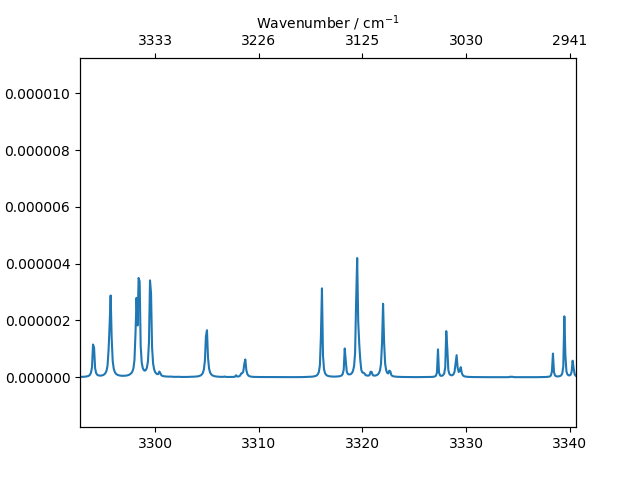

In [9]:
#plot spectrum
fig, ax=plt.subplots()
ax.plot((wl_array*1000)[::-1], alpha_c2h2)
ax.set_xlim([2900,3400])
functions.get_wavenumber_Xaxis(ax)


In [47]:
#save spectrum
#np.savetxt(r'C:\Data\Python\DGA_simulator\spectral_files\C2H4.TXT', np.column_stack([nu,alpha_c2h2]),delimiter='\t')

In [22]:
10E-6

1e-05

In [30]:
wn_array

array([2222.27160603, 2222.32099204, 2222.37038025, ..., 3999.6800256 ,
       3999.8400064 , 4000.        ])

In [50]:
0.0017*np.log(10)

0.003914394658089878

In [65]:
1.5*0.02

0.03

In [73]:
10**7/3750


2666